In [1]:
import pandas as pd
import os

import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import astropy.units as u
from astropy.table import Table, vstack
import astropy
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.time import Time
import getpass

import lsst.afw.display as afwDisplay
import lsst.afw.geom as afwGeom
import lsst.afw.image as afwImage
import lsst.afw.math as afwMath
from lsst.daf.butler import Butler
# from lsst.daf.butler.registry import ConflictingDefinitionError
import lsst.geom as geom
# from lsst.source.injection import ingest_injection_catalog, generate_injection_catalog
# from lsst.source.injection import VisitInjectConfig, VisitInjectTask
# from lsst.ip.diffim.subtractImages import AlardLuptonSubtractTask, AlardLuptonSubtractConfig
# from lsst.pipe.tasks.coaddBase import makeSkyInfo

# from lsst.pipe.tasks.characterizeImage import CharacterizeImageTask
# from lsst.pipe.tasks.makeWarp import MakeWarpTask, MakeWarpConfig
# from lsst.meas.algorithms.detection import SourceDetectionTask
# from lsst.meas.deblender import SourceDeblendTask
# from lsst.meas.base import SingleFrameMeasurementTask
# from lsst.meas.base import ForcedMeasurementTask
import lsst.daf.base as dafBase
import lsst.afw.table as afwTable

import lsst.sphgeom as sphgeom

from lsst.ctrl.mpexec import pipeline2dot
from lsst.ctrl.mpexec import SimplePipelineExecutor
from lsst.pipe.base import Pipeline, Instrument

# Define repo and collections

In [2]:
repo = '/global/cfs/cdirs/lsst/production/gen3/DC2/Run3.1i/repo'
# These are the collections containing the Y1 processed visit images, etc..
collections = ['u/descdm/sfp_ddf_visits_part_00',
               'u/descdm/sfp_ddf_visits_part_01',
               'u/descdm/sfp_ddf_visits_part_00_visit_tables',
               'u/descdm/sfp_ddf_visits_part_01_visit_tables'
              ]
# collections = ['u/jchiang8/coadds_ddf_y1-y2_4848_assembleCoadd']

In [3]:
calexp_butler = Butler(repo, collections=collections)

# Select a calexp to then extract a coordiante for reference

In [4]:
where = f"instrument='LSSTCam-imSim' AND skymap='DC2' AND \
          band='g'"
calexp_g_DatasetRefs = sorted(list(set(calexp_butler.registry.queryDatasets('calexp', where=where))))
print(f'Identified {len(calexp_g_DatasetRefs)} calexp DatasetRefs')

Identified 7410 calexp DatasetRefs


In [5]:
dataId = calexp_g_DatasetRefs[5].dataId
print(f"{dataId = }")

dataId = {instrument: 'LSSTCam-imSim', detector: 4, visit: 204414, band: 'g', day_obs: 20221004, physical_filter: 'g_sim_1.4'}


In [6]:
calexp = calexp_butler.get('calexp', dataId=dataId)
bbox = calexp.getBBox()
wcs = calexp.getWcs()
center = wcs.pixelToSky(bbox.centerX, bbox.centerY)
center

SpherePoint(53.71860108313271*degrees, -28.779074774745983*degrees)

In [7]:
wcs, bbox

(FITS standard SkyWcs:
 Sky Origin: (53.7249912323, -28.7927696630)
 Pixel Origin: (1930.09, 1754.35)
 Pixel Scale: 0.199783 arcsec/pixel,
 Box2I(corner=Point2I(0, 0), dimensions=Extent2I(4072, 4000)))

In [7]:
ra = center.getRa()
dec = center.getDec()

In [8]:
my_spherePoint = geom.SpherePoint(ra.asDegrees()*geom.degrees, dec.asDegrees()*geom.degrees)

skymap = calexp_butler.get('skyMap', skymap='DC2')
tract = skymap.findTract(my_spherePoint)
my_tract = tract.tract_id
my_patch = tract.findPatch(my_spherePoint).getSequentialIndex()
print('My tract and patch: ', my_tract, my_patch)

My tract and patch:  4849 31


# Extract dates from all the datasetRefs of calexps

In [9]:
dates = np.unique([x.dataId['day_obs'] for x in calexp_g_DatasetRefs])

In [10]:
dates

array([20211231, 20220730, 20220831, 20220902, 20220916, 20220917,
       20220919, 20221001, 20221004, 20221014, 20221017, 20221020,
       20221031, 20221103, 20221112, 20221115, 20221118, 20221129,
       20221202, 20221210, 20221213, 20221216, 20221218, 20221219])

Just checking that the tract and patch combination have calexps

In [11]:
for data_id in calexp_butler.registry.queryDataIds(
    ["tract", "visit", "detector", "patch"],
    instrument="LSSTCam-imSim",
    datasets="calexp",
    collections=collections, where=f"skymap='DC2' AND band='g' AND tract=4849 AND patch=31"# AND detector=132 AND visit=250"#AND day_obs=20220101"
).limit(100):
    print(data_id.full)

{instrument: 'LSSTCam-imSim', skymap: 'DC2', detector: 115, tract: 4849, patch: 31, visit: 242014, band: 'g', day_obs: 20221129, physical_filter: 'g_sim_1.4'}
{instrument: 'LSSTCam-imSim', skymap: 'DC2', detector: 115, tract: 4849, patch: 31, visit: 242014, band: 'g', day_obs: 20221129, physical_filter: 'g_sim_1.4'}
{instrument: 'LSSTCam-imSim', skymap: 'DC2', detector: 69, tract: 4849, patch: 31, visit: 250887, band: 'g', day_obs: 20221213, physical_filter: 'g_sim_1.4'}
{instrument: 'LSSTCam-imSim', skymap: 'DC2', detector: 69, tract: 4849, patch: 31, visit: 250887, band: 'g', day_obs: 20221213, physical_filter: 'g_sim_1.4'}
{instrument: 'LSSTCam-imSim', skymap: 'DC2', detector: 156, tract: 4849, patch: 31, visit: 225478, band: 'g', day_obs: 20221031, physical_filter: 'g_sim_1.4'}
{instrument: 'LSSTCam-imSim', skymap: 'DC2', detector: 156, tract: 4849, patch: 31, visit: 225478, band: 'g', day_obs: 20221031, physical_filter: 'g_sim_1.4'}
{instrument: 'LSSTCam-imSim', skymap: 'DC2', det

/tmp/ipykernel_302409/2616655568.py:7: FutureWarning: Call to deprecated function (or staticmethod) full. (DataCoordinate.full is deprecated in favor of .mapping, and will be dropped after v27.) -- Deprecated since version v27.
  print(data_id.full)


Extract dates for the tract and patch, just to see they are the same as the step above

In [12]:
day_obds = [x['day_obs'] for x in list(calexp_butler.registry.queryDataIds(
    ["tract", "visit", "detector", "patch"],
    instrument="LSSTCam-imSim",
    datasets="calexp",
    collections=collections, where=f"skymap='DC2' AND band='g' AND tract=4849 AND patch=31"# AND detector=132 AND visit=250"#AND day_obs=20220101"
))]

In [13]:
np.unique(day_obds)

array([20211231, 20220730, 20220831, 20220902, 20220916, 20220917,
       20220919, 20221001, 20221004, 20221014, 20221017, 20221020,
       20221031, 20221103, 20221112, 20221115, 20221118, 20221129,
       20221202, 20221210, 20221213, 20221216, 20221218, 20221219])

In [14]:
np.unique(day_obds) == dates

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

# Extract visit tables

In [15]:
visitTableRef = list(calexp_butler.registry.queryDatasets('visitTable'))

In [16]:
visitTable = pd.DataFrame()
for v in visitTableRef:
    visitTable_uni = calexp_butler.get(v)
    visitTable_uni = visitTable_uni[visitTable_uni['band'] == 'g']
    visitTable = pd.concat([visitTable,visitTable_uni])

In [17]:
visitTable

,visit,physical_filter,band,ra,decl,skyRotation,azimuth,altitude,zenithDistance,airmass,obsStart,expTime
visitId,,,,,,,,,,,,
250,250,g_sim_1.4,g,52.943426,-27.504549,112.222253,268.049586,62.908761,27.091239,1.113911,2022-01-01 03:35:25.545800,30.0
251,251,g_sim_1.4,g,53.056448,-27.474710,84.536413,268.096550,62.869524,27.130476,1.114277,2022-01-01 03:36:01.574200,30.0
252,252,g_sim_1.4,g,53.070371,-27.537180,84.414365,267.902653,62.765900,27.234100,1.115245,2022-01-01 03:36:37.603100,30.0
253,253,g_sim_1.4,g,53.001404,-27.372560,84.731444,268.153524,62.538675,27.461325,1.117386,2022-01-01 03:37:13.545800,30.0
254,254,g_sim_1.4,g,53.001653,-27.458387,84.566903,267.905714,62.428878,27.571122,1.118430,2022-01-01 03:37:49.574200,30.0
...,...,...,...,...,...,...,...,...,...,...,...,...
254939,254939,g_sim_1.4,g,53.086701,-27.514895,59.936891,74.287582,81.201104,8.798896,1.012526,2022-12-20 01:42:50.880000,30.0
254940,254940,g_sim_1.4,g,53.049559,-27.353720,58.963644,72.907057,81.298642,8.701358,1.012258,2022-12-20 01:43:26.822200,30.0
254941,254941,g_sim_1.4,g,52.953957,-27.373719,58.936572,72.489014,81.509067,8.490933,1.011692,2022-12-20 01:44:02.851100,30.0


## Convert visit dates to julian date

In [18]:
visitTable.loc[:, 'jd'] = visitTable.loc[:, 'obsStart'].map(lambda x: x.to_julian_date())
visitTable.loc[:, 'jd'] = visitTable.loc[:, 'jd'].map(lambda x: round(x,0))

## Convert calexps dates to julian date

In [19]:
dates_calexps = pd.DataFrame()
dates_calexps.loc[:, 'year'] = [str(x)[:4] for x in day_obds]
dates_calexps.loc[:, 'month'] = [str(x)[4:6] for x in day_obds]
dates_calexps.loc[:, 'day'] = [str(x)[6:] for x in day_obds]
dates_calexps.loc[:, 'time'] = dates_calexps.loc[:, 'year']+'-'+dates_calexps.loc[:, 'month']+'-'+dates_calexps.loc[:, 'day']
dates_calexps.loc[:, 'time'] = dates_calexps.loc[:, 'time'].map(lambda x: Time(x))
dates_calexps.loc[:, 'jd'] = dates_calexps.loc[:, 'time'].map(lambda x: x.jd)
dates_calexps.loc[:, 'jd'] = dates_calexps.loc[:, 'jd'].map(lambda x: round(x,0))

In [37]:
dates_calexps.groupby('jd').size()

jd
2459580.0    29
2459790.0     2
2459822.0     2
2459824.0    37
2459838.0    32
2459840.0     2
2459842.0    39
2459854.0    32
2459856.0    28
2459866.0    25
2459870.0    34
2459872.0    29
2459884.0    39
2459886.0    21
2459896.0    26
2459898.0    24
2459902.0    22
2459912.0    31
2459916.0    37
2459924.0    20
2459926.0    30
2459930.0    26
2459932.0    42
dtype: int64

In [38]:
dates_calexps.groupby('jd').agg({'time': 'first'})

,time
jd,
2459580.0,2021-12-31 00:00:00.000
2459790.0,2022-07-30 00:00:00.000
2459822.0,2022-08-31 00:00:00.000
2459824.0,2022-09-02 00:00:00.000
2459838.0,2022-09-16 00:00:00.000
2459840.0,2022-09-17 00:00:00.000
2459842.0,2022-09-19 00:00:00.000
2459854.0,2022-10-01 00:00:00.000
2459856.0,2022-10-04 00:00:00.000


# Select the visits that fall within the 1st and 2nd time of the calexps

In [47]:
my_range = np.array((visitTable['jd'] >= np.unique(dates_calexps['jd'])[3]) & 
                    (visitTable['jd'] < np.unique(dates_calexps['jd'])[4]))


# my_range2 = np.array((visitTable['jd'] > np.unique(dates_calexps['jd'])[2]) & 
#                     (visitTable['jd'] <= np.unique(dates_calexps['jd'])[3]))

In [48]:
# my_range2 + my_range

In [49]:
my_visits = visitTable.visit[my_range]
my_visits_tupleString = "("+",".join(my_visits.astype(str))+")"
print(my_visits_tupleString)

(183767,183768,183809,183811,183812,185615,185616,185617,185618,185619,185620,185621,185622,185623,185624,185735,185736,185783,185785)


Just checking there're calexp for the tract, patch and visits

In [50]:
for data_id in calexp_butler.registry.queryDataIds(
    ["tract", "visit", "detector", "patch"],
    instrument="LSSTCam-imSim",
    datasets="calexp",
    collections=collections, where=f"skymap='DC2' AND band='g' AND tract=4849 AND patch=31 AND visit in {my_visits_tupleString}"#AND day_obs=20211231"# AND detector=132 AND visit=250"#AND day_obs=20220101"
).limit(100):
    print(data_id.full)

{instrument: 'LSSTCam-imSim', skymap: 'DC2', detector: 86, tract: 4849, patch: 31, visit: 183811, band: 'g', day_obs: 20220831, physical_filter: 'g_sim_1.4'}
{instrument: 'LSSTCam-imSim', skymap: 'DC2', detector: 86, tract: 4849, patch: 31, visit: 183811, band: 'g', day_obs: 20220831, physical_filter: 'g_sim_1.4'}
{instrument: 'LSSTCam-imSim', skymap: 'DC2', detector: 76, tract: 4849, patch: 31, visit: 185615, band: 'g', day_obs: 20220902, physical_filter: 'g_sim_1.4'}
{instrument: 'LSSTCam-imSim', skymap: 'DC2', detector: 76, tract: 4849, patch: 31, visit: 185615, band: 'g', day_obs: 20220902, physical_filter: 'g_sim_1.4'}
{instrument: 'LSSTCam-imSim', skymap: 'DC2', detector: 122, tract: 4849, patch: 31, visit: 185616, band: 'g', day_obs: 20220902, physical_filter: 'g_sim_1.4'}
{instrument: 'LSSTCam-imSim', skymap: 'DC2', detector: 122, tract: 4849, patch: 31, visit: 185616, band: 'g', day_obs: 20220902, physical_filter: 'g_sim_1.4'}
{instrument: 'LSSTCam-imSim', skymap: 'DC2', detec

/tmp/ipykernel_302409/3020545707.py:7: FutureWarning: Call to deprecated function (or staticmethod) full. (DataCoordinate.full is deprecated in favor of .mapping, and will be dropped after v27.) -- Deprecated since version v27.
  print(data_id.full)


In [51]:
visitTable[my_range]

,visit,physical_filter,band,ra,decl,skyRotation,azimuth,altitude,zenithDistance,airmass,obsStart,expTime,jd
visitId,,,,,,,,,,,,,
183767,183767,g_sim_1.4,g,51.682527,-28.027720,338.015794,96.132669,56.199235,33.800765,1.198199,2022-09-01 06:53:05.587100,30.0,2459824.0
183768,183768,g_sim_1.4,g,51.686828,-29.590692,340.290324,98.843617,56.663183,33.336817,1.191937,2022-09-01 06:53:44.208000,30.0,2459824.0
183809,183809,g_sim_1.4,g,52.755108,-25.821604,333.130080,89.385309,60.892021,29.107979,1.141959,2022-09-01 07:21:40.108900,30.0,2459824.0
183811,183811,g_sim_1.4,g,53.244325,-28.918670,338.517372,95.704938,61.478329,28.521671,1.135613,2022-09-01 07:22:57.609800,30.0,2459824.0
183812,183812,g_sim_1.4,g,51.689473,-29.908798,340.679684,97.258178,63.121202,26.878798,1.119182,2022-09-01 07:23:36.662200,30.0,2459824.0
185615,185615,g_sim_1.4,g,53.034002,-27.393355,65.237403,97.623811,50.140114,39.859886,1.292209,2022-09-03 06:23:10.195100,30.0,2459826.0
185616,185616,g_sim_1.4,g,52.934748,-27.438014,89.693447,97.599873,50.365465,39.634535,1.288211,2022-09-03 06:23:46.137800,30.0,2459826.0
185617,185617,g_sim_1.4,g,53.074379,-27.443361,89.674838,97.603975,50.376204,39.623796,1.288018,2022-09-03 06:24:22.166200,30.0,2459826.0
185618,185618,g_sim_1.4,g,52.886790,-27.444196,89.708627,97.481481,50.665991,39.334009,1.282947,2022-09-03 06:24:58.195100,30.0,2459826.0


# Create the butler for the ouputs of the pipeline

In [52]:
my_collection_identifier = 'custom_coadd_test_2_442025'
print(my_collection_identifier)

custom_coadd_test_2_442025


In [53]:
user = os.getenv("USER")
print(user)

taceroc


In [54]:
my_outputCollection = f"u/{user}/{my_collection_identifier}"
print('Name of new butler collection for my output: ', my_outputCollection)

Name of new butler collection for my output:  u/taceroc/custom_coadd_test_2_442025


# Define the bulter

In [55]:
simpleButler = SimplePipelineExecutor.prep_butler(repo, 
                                                  inputs=collections, 
                                                  output=my_outputCollection)

In [56]:
simpleButler.registry.getCollectionChain(my_outputCollection)

('u/taceroc/custom_coadd_test_2_442025/20250404T182024Z',
 'u/descdm/sfp_ddf_visits_part_00',
 'u/descdm/sfp_ddf_visits_part_01',
 'u/descdm/sfp_ddf_visits_part_00_visit_tables',
 'u/descdm/sfp_ddf_visits_part_01_visit_tables')

In [57]:
! echo $DRP_PIPE_DIR

/cvmfs/sw.lsst.eu/linux-x86_64/lsst_distrib/v27.0.0/conda/envs/lsst-scipipe-8.0.0-exact-ext/share/eups/Linux64/drp_pipe/gfa69e0f95e+cb6a7025ff


## Run like this for now, no whole step3

In [58]:
yaml_file = '$DRP_PIPE_DIR/pipelines/LSSTCam-imSim/DRP-test-med-1.yaml'
steps = 'step1,step2,makeWarp,selectDeepCoaddVisits,assembleCoadd,detection,mergeDetections,deblend,measure'
# steps = 'step1,step2,step3'
my_uri = yaml_file + '#' + steps
print(my_uri)

$DRP_PIPE_DIR/pipelines/LSSTCam-imSim/DRP-test-med-1.yaml#step1,step2,makeWarp,selectDeepCoaddVisits,assembleCoadd,detection,mergeDetections,deblend,measure


In [59]:
assembleCoaddPipeline = Pipeline.from_uri(my_uri)

leave all as the default, then maybe change it

In [60]:
# assembleCoaddPipeline.addConfigOverride('makeWarp', 
#                                         'connections.visitSummary', 
#                                         "visitSummary")
# assembleCoaddPipeline.addConfigOverride('makeWarp', 
#                                         'doWriteEmptyWarps', 
#                                         True)
# assembleCoaddPipeline.addConfigOverride('makeWarp', 
#                                         'useVisitSummaryPsf', 
#                                         False)
# assembleCoaddPipeline.addConfigOverride('assembleCoadd', 'doSelectVisits', False)

In [61]:
# pipeline2dot(assembleCoaddPipeline, "/global/homes/t/taceroc/custom_coadd_qgraph.dot")

# ! dot -Tpng "/global/homes/t/taceroc/custom_coadd_qgraph.dot" > "/global/homes/t/taceroc/custom_coadd_qgraph.png"

/cvmfs/sw.lsst.eu/linux-x86_64/lsst_distrib/v27.0.0/conda/envs/lsst-scipipe-8.0.0-exact-ext/share/eups/Linux64/obs_lsst/g5c5439fafc+141fc35c6f/config/assembleCoadd.py:28: FutureWarning: Config field doSigmaClip is deprecated: True
  config.doSigmaClip = False


# Define query for tract, patch and visits

In [62]:
queryString = f"tract = {my_tract} AND patch = {my_patch} AND " + \
              f"visit in {my_visits_tupleString} AND skymap = 'DC2'"
print(queryString)

tract = 4849 AND patch = 31 AND visit in (183767,183768,183809,183811,183812,185615,185616,185617,185618,185619,185620,185621,185622,185623,185624,185735,185736,185783,185785) AND skymap = 'DC2'


In [63]:
spe = SimplePipelineExecutor.from_pipeline(assembleCoaddPipeline, 
                                           where=queryString, 
                                           butler=simpleButler)

/cvmfs/sw.lsst.eu/linux-x86_64/lsst_distrib/v27.0.0/conda/envs/lsst-scipipe-8.0.0-exact-ext/share/eups/Linux64/obs_lsst/g5c5439fafc+141fc35c6f/config/assembleCoadd.py:28: FutureWarning: Config field doSigmaClip is deprecated: True
  config.doSigmaClip = False


# Run the pipeline

In [64]:
quanta = spe.run('--register-dataset-types')

Traceback (most recent call last):
  File "/cvmfs/sw.lsst.eu/linux-x86_64/lsst_distrib/v27.0.0/conda/envs/lsst-scipipe-8.0.0-exact-ext/share/eups/Linux64/meas_extensions_scarlet/g1850869495+d7bfc87f51/python/lsst/meas/extensions/scarlet/scarletDeblendTask.py", line 946, in deblend
    blend, skippedSources, skippedBands = deblend(
                                          ^^^^^^^^
  File "/cvmfs/sw.lsst.eu/linux-x86_64/lsst_distrib/v27.0.0/conda/envs/lsst-scipipe-8.0.0-exact-ext/share/eups/Linux64/meas_extensions_scarlet/g1850869495+d7bfc87f51/python/lsst/meas/extensions/scarlet/scarletDeblendTask.py", line 137, in deblend
    observation = buildObservation(
                  ^^^^^^^^^^^^^^^^^
  File "/cvmfs/sw.lsst.eu/linux-x86_64/lsst_distrib/v27.0.0/conda/envs/lsst-scipipe-8.0.0-exact-ext/share/eups/Linux64/meas_extensions_scarlet/g1850869495+d7bfc87f51/python/lsst/meas/extensions/scarlet/utils.py", line 190, in buildObservation
    psfModels, mExposure = computePsfKernelImage(mExpo

check that all seems fine

In [65]:
for q, quantum in enumerate(quanta):
    print(q, quantum.taskName)

0 lsst.ip.isr.isrTask.IsrTask
1 lsst.ip.isr.isrTask.IsrTask
2 lsst.ip.isr.isrTask.IsrTask
3 lsst.ip.isr.isrTask.IsrTask
4 lsst.ip.isr.isrTask.IsrTask
5 lsst.ip.isr.isrTask.IsrTask
6 lsst.ip.isr.isrTask.IsrTask
7 lsst.ip.isr.isrTask.IsrTask
8 lsst.ip.isr.isrTask.IsrTask
9 lsst.ip.isr.isrTask.IsrTask
10 lsst.ip.isr.isrTask.IsrTask
11 lsst.ip.isr.isrTask.IsrTask
12 lsst.ip.isr.isrTask.IsrTask
13 lsst.ip.isr.isrTask.IsrTask
14 lsst.ip.isr.isrTask.IsrTask
15 lsst.ip.isr.isrTask.IsrTask
16 lsst.ip.isr.isrTask.IsrTask
17 lsst.ip.isr.isrTask.IsrTask
18 lsst.ip.isr.isrTask.IsrTask
19 lsst.ip.isr.isrTask.IsrTask
20 lsst.pipe.tasks.characterizeImage.CharacterizeImageTask
21 lsst.pipe.tasks.characterizeImage.CharacterizeImageTask
22 lsst.pipe.tasks.characterizeImage.CharacterizeImageTask
23 lsst.pipe.tasks.characterizeImage.CharacterizeImageTask
24 lsst.pipe.tasks.characterizeImage.CharacterizeImageTask
25 lsst.pipe.tasks.characterizeImage.CharacterizeImageTask
26 lsst.pipe.tasks.characterizeImage

# Check if the coadd exists

In [66]:
list(simpleButler.registry.queryDatasets('deepCoadd'))

[DatasetRef(DatasetType('deepCoadd', {band, skymap, tract, patch}, ExposureF), {band: 'g', skymap: 'DC2', tract: 4849, patch: 31}, run='u/taceroc/custom_coadd_test_2_442025/20250404T182024Z', id=63fc527d-54e0-4203-9080-31287c23b4fe)]

In [67]:
deepCoadd_test = simpleButler.get(list(simpleButler.registry.queryDatasets('deepCoadd'))[0])

In [68]:
afwDisplay.setDefaultBackend('matplotlib')
plt.style.use('tableau-colorblind10')

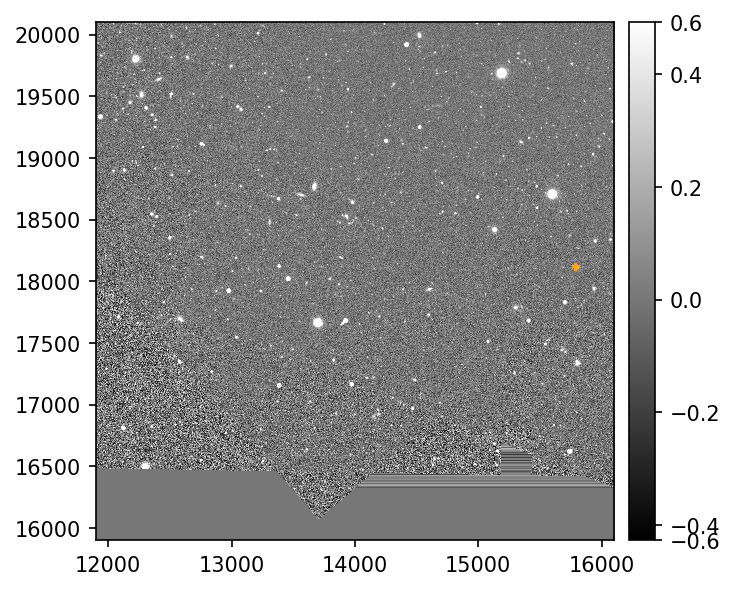

In [69]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=150)

display2 = afwDisplay.Display(frame=fig)
display2.scale('linear', 'zscale')
# display2.scale('linear', min=-20, max=150)
display2.mtv(deepCoadd_test.image)
wcs = deepCoadd_test.getWcs()
center = wcs.skyToPixel(geom.SpherePoint(ra, dec))
display2.dot('+', center.x, center.y, size=20, ctype='orange')
# To zoom on the PGC 038749 stamp:
# display2.mtv(result.difference.image[xy[0]+100:xy[0]-100, xy[1]+100:xy[1]-100])#[3510:3560, 1750:1800])
# plt.title(f"warp {my_coadd_visits_mjds['mjd'].unique()[0]} to {my_coadd_visits_mjds['mjd'].unique()[1]}")

plt.tight_layout()
plt.show()

In [70]:
list(simpleButler.registry.queryDatasets('deepCoadd_meas'))

[DatasetRef(DatasetType('deepCoadd_meas', {band, skymap, tract, patch}, SourceCatalog), {band: 'g', skymap: 'DC2', tract: 4849, patch: 31}, run='u/taceroc/custom_coadd_test_2_442025/20250404T182024Z', id=fb47e7e5-aca5-4c03-badb-9ab31a478fc2)]

In [71]:
deepCoadd_src = simpleButler.get(list(simpleButler.registry.queryDatasets('deepCoadd_meas'))[0])

In [72]:
len(deepCoadd_src.asAstropy())

12305

In [73]:
deepCoadd_src.asAstropy()

id,coord_ra,coord_dec,parent,merge_footprint_i,merge_footprint_r,merge_footprint_z,merge_footprint_y,merge_footprint_g,merge_footprint_u,merge_footprint_sky,merge_peak_i,merge_peak_r,merge_peak_z,merge_peak_y,merge_peak_g,merge_peak_u,merge_peak_sky,deblend_runtime,deblend_iterations,deblend_nChild,deblend_nPeaks,deblend_skipped,deblend_isolatedParent,deblend_isPseudo,deblend_tooManyPeaks,deblend_parentTooBig,deblend_masked,deblend_sedConvergenceFailed,deblend_morphConvergenceFailed,deblend_blendConvergenceFailedFlag,deblend_failed,deblend_error,deblend_incompleteData,deblend_peak_center_x,deblend_peak_center_y,deblend_peakId,deblend_peak_instFlux,deblend_modelType,deblend_parentNPeaks,deblend_parentNChild,deblend_scarletFlux,deblend_logL,deblend_edgePixels,deblend_spectrumInitFlag,deblend_nComponents,deblend_deblendedAsPsf,deblend_dataCoverage,deblend_zeroFlux,deblend_maxOverlap,deblend_fluxOverlap,deblend_fluxOverlapFraction,deblend_blendedness,coord_raErr,coord_decErr,coord_ra_dec_Cov,base_SdssCentroid_x,slot_Centroid_x,base_SdssCentroid_y,slot_Centroid_y,base_SdssCentroid_xErr,slot_Centroid_xErr,base_SdssCentroid_yErr,slot_Centroid_yErr,base_SdssCentroid_flag,base_CircularApertureFlux_flag_badCentroid,base_GaussianFlux_flag_badCentroid,base_InputCount_flag_badCentroid,base_LocalBackground_flag_badCentroid,base_PsfFlux_flag_badCentroid,base_SdssShape_flag_badCentroid,base_Variance_flag_badCentroid,ext_convolved_ConvolvedFlux_0_flag_badCentroid,ext_convolved_ConvolvedFlux_1_flag_badCentroid,ext_convolved_ConvolvedFlux_2_flag_badCentroid,ext_convolved_ConvolvedFlux_3_flag_badCentroid,ext_convolved_ConvolvedFlux_flag_badCentroid,ext_photometryKron_KronFlux_flag_badInitialCentroid,ext_shapeHSM_HigherOrderMomentsPSF_flag_badCentroid,ext_shapeHSM_HsmPsfMomentsDebiased_flag_badCentroid,ext_shapeHSM_HsmPsfMoments_flag_badCentroid,ext_shapeHSM_HsmShapeRegauss_flag_badCentroid,ext_shapeHSM_HsmSourceMomentsRound_flag_badCentroid,ext_shapeHSM_HsmSourceMoments_flag_badCentroid,modelfit_DoubleShapeletPsfApprox_flag_badCentroid,slot_Centroid_flag,base_SdssCentroid_flag_edge,base_CircularApertureFlux_flag_badCentroid_edge,base_GaussianFlux_flag_badCentroid_edge,base_InputCount_flag_badCentroid_edge,base_LocalBackground_flag_badCentroid_edge,base_PsfFlux_flag_badCentroid_edge,base_SdssShape_flag_badCentroid_edge,base_Variance_flag_badCentroid_edge,ext_convolved_ConvolvedFlux_0_flag_badCentroid_edge,ext_convolved_ConvolvedFlux_1_flag_badCentroid_edge,ext_convolved_ConvolvedFlux_2_flag_badCentroid_edge,ext_convolved_ConvolvedFlux_3_flag_badCentroid_edge,ext_convolved_ConvolvedFlux_flag_badCentroid_edge,ext_photometryKron_KronFlux_flag_badInitialCentroid_edge,ext_shapeHSM_HigherOrderMomentsPSF_flag_badCentroid_edge,ext_shapeHSM_HsmPsfMomentsDebiased_flag_badCentroid_edge,ext_shapeHSM_HsmPsfMoments_flag_badCentroid_edge,ext_shapeHSM_HsmShapeRegauss_flag_badCentroid_edge,ext_shapeHSM_HsmSourceMomentsRound_flag_badCentroid_edge,ext_shapeHSM_HsmSourceMoments_flag_badCentroid_edge,modelfit_DoubleShapeletPsfApprox_flag_badCentroid_edge,slot_Centroid_flag_edge,base_SdssCentroid_flag_noSecondDerivative,base_CircularApertureFlux_flag_badCentroid_noSecondDerivative,base_GaussianFlux_flag_badCentroid_noSecondDerivative,base_InputCount_flag_badCentroid_noSecondDerivative,base_LocalBackground_flag_badCentroid_noSecondDerivative,base_PsfFlux_flag_badCentroid_noSecondDerivative,base_SdssShape_flag_badCentroid_noSecondDerivative,base_Variance_flag_badCentroid_noSecondDerivative,ext_convolved_ConvolvedFlux_0_flag_badCentroid_noSecondDerivative,ext_convolved_ConvolvedFlux_1_flag_badCentroid_noSecondDerivative,ext_convolved_ConvolvedFlux_2_flag_badCentroid_noSecondDerivative,ext_convolved_ConvolvedFlux_3_flag_badCentroid_noSecondDerivative,ext_convolved_ConvolvedFlux_flag_badCentroid_noSecondDerivative,ext_photometryKron_KronFlux_flag_badInitialCentroid_noSecondDerivative,ext_shapeHSM_HigherOrderMomentsPSF_flag_badCentroid_noSecondDerivative,ext_shapeHSM_HsmPsfM

In [74]:
deepCoadd_src.asAstropy().to_pandas().columns

Index(['id', 'coord_ra', 'coord_dec', 'parent', 'merge_footprint_i',
       'merge_footprint_r', 'merge_footprint_z', 'merge_footprint_y',
       'merge_footprint_g', 'merge_footprint_u',
       ...
       'slot_ModelFlux_exp_flag_apCorr', 'modelfit_CModel_initial_apCorr',
       'slot_ModelFlux_initial_apCorr', 'modelfit_CModel_initial_apCorrErr',
       'slot_ModelFlux_initial_apCorrErr',
       'modelfit_CModel_initial_flag_apCorr',
       'slot_ModelFlux_initial_flag_apCorr',
       'base_ClassificationExtendedness_value',
       'base_ClassificationExtendedness_flag', 'base_FootprintArea_value'],
      dtype='object', length=948)

In [75]:
deepCoadd_src.asAstropy().to_pandas()[deepCoadd_src.asAstropy().to_pandas()['deblend_runtime'] > 0]

,id,coord_ra,coord_dec,parent,merge_footprint_i,merge_footprint_r,merge_footprint_z,merge_footprint_y,merge_footprint_g,merge_footprint_u,...,slot_ModelFlux_exp_flag_apCorr,modelfit_CModel_initial_apCorr,slot_ModelFlux_initial_apCorr,modelfit_CModel_initial_apCorrErr,slot_ModelFlux_initial_apCorrErr,modelfit_CModel_initial_flag_apCorr,slot_ModelFlux_initial_flag_apCorr,base_ClassificationExtendedness_value,base_ClassificationExtendedness_flag,base_FootprintArea_value
0,2090233177053331457,0.939885,-0.504270,0,False,False,False,False,True,False,...,False,1.002725,1.002725,0.0,0.0,False,False,NaN,True,181
1,2090233177053331458,0.939874,-0.504216,0,False,False,False,False,True,False,...,False,1.002184,1.002184,0.0,0.0,False,False,NaN,True,177
2,2090233177053331459,0.939911,-0.504211,0,False,False,False,False,True,False,...,False,1.001939,1.001939,0.0,0.0,False,False,1.0,False,121
3,2090233177053331460,0.939872,-0.504145,0,False,False,False,False,True,False,...,False,1.001432,1.001432,0.0,0.0,False,False,0.0,False,92
4,2090233177053331461,0.939664,-0.504128,0,False,False,False,False,True,False,...,False,1.002293,1.002293,0.0,0.0,False,False,NaN,True,152
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5106,2090233177053336563,0.939162,-0.500383,0,False,False,False,False,True,False,...,False,0.991338,0.991338,0.0,0.0,False,False,NaN,True,316
5107,2090233177053336564,0.940799,-0.500399,0,False,False,False,False,True,False,...,False,0.994195,0.994195,0.0,0.0,False,False,NaN,True,1082
5108,2090233177053336565,0.940735,-0.500383,0,False,False,False,False,True,False,...,False,0.994132,0.994132,0.0,0.0,False,False,NaN,True,196
5109,2090233177053336566,0.937495,-0.500383,0,False,False,False,False,True,False,...,False,0.987530,0.987530,0.0,0.0,False,False,NaN,True,125
